# Geemap Workflow for Earth Engine Classified Images with Locally Tuned and Trained Classifiers

## This Jupyter Notebook describes a geospatial workflow using geemap and an adapted LandTrendr JavaScript module to create classified images in Google Earth Engine. 
## The workflow involves using locally tuned, trained, and saved classifiers, and the geemap ml module to upload and use the classifiers for image classification. 
## The classified images are uploaded as assets for later analysis.

### The notebook demonstrates step-by-step how to:

- Set up the Python environment and authenticate with Google Earth Engine
- Load and visualize satellite image collections using geemap
- Adapt and run a LandTrendr JavaScript module in Google Earth Engine to create time-series data
- Train and locally tune a machine learning classifier using geemap
- Save the trained classifier locally and upload it to Google Earth Engine
- Apply the trained classifier to the LandTrendr time-series data to generate classified images
- Upload the classified images to Google Earth Engine as assets for further analysis

This workflow provides a powerful and flexible tool for processing and analyzing large geospatial datasets, making it useful for a wide range of applications such as land cover and land use change detection, urban planning, and natural resource management.

In [1]:
import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

today = dt.today()

## GEE Authentication

Before using the Earth Engine Python API, we need to authenticate our account. The authentication step is required for the first time you use Earth Engine in a new session and roughly every week thereafter.

To authenticate, run the following cell and follow the prompts to log into your Earth Engine account. You will then be prompted to copy and paste the authentication code into the box provided. Once you have pasted the code, press enter to save the token.


In [2]:
# ee.Authenticate()

geemap.ee_initialize()

### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available

In [3]:
# set the path and version of the input data
p = '..'
version = 'Version_3_20230303'

# read in the list of catchment IDs from the input csv file
l = pd.read_csv(f"{p}/Inputs/{version}/GB.csv").ID

# display the list of catchment IDs and convert it to a Python list
names = l.tolist()

# print the number of catchments and their IDs
print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')


95 catchments processed for hydroclimatic variables:
 
[17005, 18001, 20007, 21017, 21023, 21024, 22001, 23004, 24004, 25006, 26003, 27035, 27042, 27047, 27051, 27071, 28046, 28072, 29003, 29009, 30004, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 34011, 36003, 36009, 36010, 37005, 38026, 39017, 39019, 39020, 39025, 39034, 40005, 40011, 41022, 41025, 41027, 41029, 42003, 43014, 45005, 46003, 46005, 47009, 48003, 48004, 49004, 50002, 52010, 52016, 53006, 53008, 53009, 53017, 54008, 54018, 54025, 54034, 54036, 55008, 55014, 55016, 55026, 55029, 56013, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 68005, 71001, 71004, 72005, 73005, 73011, 75017, 76014, 77004, 78004, 79002, 79004, 8009, 93001, 94001]


## Load the JS Module

This notebook uses an adapted landTrendr package to construct time series of Landsat imagery for land cover detection. The package is optimized for deforestation event detection and can be used with the latest version of landTrendr available in the GEE asset, which has an Apache license and is free to use.

To load the package, we use the ltgee.buildSRcollection method. Note that if the JavaScript module is faulty, the cell below will not load.

In [4]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v7.3.js')

#ltgee.availability  #all functions within the javascript module



IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the aut/or: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 08/03/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)


## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository

Assigning some useful variables for later classification

Catchment Assets are available at this address:

https://code.earthengine.google.com/?asset=projects/mohanrahan/assets/CATAPUCII_Catchments


## Assigning useful variables

- The asset_dir will point to the shapefile loaded as a GEE table asset. 
- crs is important for reprojection and scaling (which will affect area calculations)
- RGB_VIS is for landsat RGB visual parameters
- start day defines the beginning of the seasonal composite period
- maskThese applies a mask (renders Null/NA/Transparent) to those majority pixels in landsat imagery

In [5]:
# Directory where assets are stored
asset_dir = 'projects/mohanrahan/assets'

# Asset ID for catchment boundaries
catchment_asset = 'CATAPUCII_Catchments/CAMELS_GB_catchment_boundaries'

# Name of the dataset
dataset = 'CAMELS_GB'

# Column string to identify catchments
col_string  = 'ID'

# Coordinate reference system, GB is british national grid
crs = 'EPSG:27700'

# Figure number for plotting
fignum = 0

# RGB visualization settings for Landsat imagery
RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

#Classified image visualisation
lc_vis = {'bands':['landcover'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}

#Classified image visualisation
class_vis = {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}

# Start and end years for Landsat data collection
startYear = 1984
endYear = 2022

# Start and end days for Landsat data collection
startDay = '06-20'
endDay = '08-31'

# List of images to be masked from Landsat collection
maskThese = ['cloud', 'shadow', 'snow',]

# List of bands to include in Landsat collection
bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 


## The Table Data

### Code:
The code imports a feature collection of catchment boundaries from the Google Earth Engine (GEE) asset directory, calculates the area of each catchment in square kilometers and pixels, sets a unique identifier for each catchment, and filters and sorts the catchment collection based on the area. It then converts the filtered and sorted collection to a pandas dataframe, selects only the catchments that are specified in a list of catchment names, and saves the resulting table to an Excel file.

### Summary:
The code fetches catchment boundaries from a GEE asset directory and calculates their areas in both square kilometers and pixels. Then, it assigns a unique identifier to each catchment and filters and sorts them based on their area. It saves a subset of the resulting catchment table that contains only the catchments specified in a list of names to an Excel file.

In [6]:
# Define the feature collection from asset directory and catchment asset name
table = ee.FeatureCollection(f"{asset_dir}/{catchment_asset}")

# Define a function to calculate the area of each geometry in square kilometer
def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

# Define a function to calculate the area of each geometry in pixels
def set_area_pixel(feature):
    '''
    Calculate the area of each geometry in pixels
    '''
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':crs,
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

# Define a function to set the system ID as a column
def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

# Calculate the area of each geometry and set ID column and pixel area column
table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)

# Filter out geometries with area_km2 equal to zero and sort by area from largest to smallest
Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)

# Convert the sorted table to a Pandas dataframe and set the index to 'system_index'
down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

# Select the rows of 'down' where the column specified by 'col_string' is in the list 'names'
df1 = down.loc[down[col_string].isin(names)]

# Get the system_index values as a list
sys_index = df1.index.to_list()

# Display the filtered table
display(df1)

# Print the number of features in the filtered table
print(len(df1))

# Convert the filtered and sorted table to a Pandas dataframe
gdf = geemap.ee_to_pandas(Filtered_Sorted)

# Create a directory for the output if it doesn't exist
if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

# Export the filtered and sorted table to an Excel file
gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx', index=0)

,pixel_area,area_km2,SOURCE,VERSION,ID,EXPORTED,ID_STRING
system_index,,,,,,,
00000000000000000088,1355.679450,1349.764903,National River Flow Archive,1.3,27071,1518422400000,27071
00000000000000000235,1145.767150,1140.885961,National River Flow Archive,1.3,71001,1518422400000,71001
000000000000000001c0,1125.603290,1121.172318,National River Flow Archive,1.3,54008,1518422400000,54008
00000000000000000207,897.948531,894.478359,National River Flow Archive,1.3,62001,1518422400000,62001
0000000000000000025a,798.157955,794.507522,National River Flow Archive,1.3,79002,1518422400000,79002
...,...,...,...,...,...,...,...
0000000000000000021b,12.768404,12.719149,National River Flow Archive,1.3,67010,1518422400000,67010
00000000000000000082,11.353532,11.304831,National River Flow Archive,1.3,27047,1518422400000,27047
000000000000000001df,10.506362,10.466687,National River Flow Archive,1.3,55008,1518422400000,55008


95


In [7]:
geom_north = {
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        -5.735496279653574,
        56.12064673783441
      ],
      [
        -3.5711896390285736,
        56.12064673783441
      ],
      [
        -3.5711896390285736,
        57.83265981722564
      ],
      [
        -5.735496279653574,
        57.83265981722564
      ],
      [
        -5.735496279653574,
        56.12064673783441
      ]
    ]
  ]
}

geom_middle = {
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        -4.439109560903574,
        53.67024054287634
      ],
      [
        -0.26430487340357356,
        53.67024054287634
      ],
      [
        -0.26430487340357356,
        56.08388347961458
      ],
      [
        -4.439109560903574,
        56.08388347961458
      ],
      [
        -4.439109560903574,
        53.67024054287634
      ]
    ]
  ]
}

geom_south = {
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        -5.372947451528574,
        50.23970424688909
      ],
      [
        1.1694109469089264,
        50.23970424688909
      ],
      [
        1.1694109469089264,
        53.458178051023836
      ],
      [
        -5.372947451528574,
        53.458178051023836
      ],
      [
        -5.372947451528574,
        50.23970424688909
      ]
    ]
  ]
}

geom_tup_ls = [('north_zone', geom_north), ('middle_zone', geom_middle), ('south_zone',geom_south)]

aoi = ee.Geometry(geom_south)

catchments = Filtered_Sorted.filter(ee.Filter.inList(col_string, ee.List(names)))

def aoi_list_to_df(catchments, tup):
    '''
    Takes a list of tuples containing [(zone names, geojson geometry),...]
    '''
    for i, j in tup:
        print('i', i)
        
        aoi = ee.Geometry(j)
        
        # Convert the filtered and sorted table to a Pandas dataframe
        gdf = geemap.ee_to_pandas(catchments.filter(ee.Filter.bounds(aoi)))
        
        # Export the filtered and sorted table to an Excel file
        gdf.to_excel(f'../Outputs/{dataset}/{dataset}_{i}_catchment_table.xlsx', index=0)

aoi_list_to_df(catchments, geom_tup_ls)

Map = geemap.Map()

Map.setOptions('TERRAIN')
Map.addLayer(catchments, {'color': 'green'}, 'green: Included')
Map.addLayer(catchments.filter(ee.Filter.bounds(aoi).Not()), {'color':'red'}, 'red: Not Included')
Map.centerObject(Filtered_Sorted, 7)
Map.addLayer(aoi, {'color':'yellow'}, 'area trained')

Map

i north_zone
i middle_zone
i south_zone


Map(center=[53.49722684216607, -2.3029239738111555], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [8]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)


def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds):
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i, yc, classified, trainingClassImage, ms, classImageYear, name, accuracy, pixArea):

    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pixArea
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted

def import_classifier(dataset: str, class_name: str, year_trained: int) -> ee.Classifier.decisionTree:
    """
    Imports a trained random forest classifier from a specified file path.

    Args:
        dataset (str): Name of the dataset.
        seg (str): Segmentation method used for training the classifier.
        year_trained (int): Year when the classifier was trained.

    Returns:
        RandomForestClassifier: A trained random forest classifier.

    Example:
        import_classifier('my_dataset', 'segmentation_method', 2022)

    Notes:
        This function assumes that the classifier has been trained and saved in the specified file path
        with the naming convention 'GB_{seg}_HC_tuned_{year_trained}'.
    """
    classifier = ml.csv_to_classifier(f'../Outputs/{dataset}/Trees/{class_name}_{year_trained}')
    return classifier


def calculate_classification_stats(confusion_matrix):
    # Calculate the total number of predictions
    total = np.sum(confusion_matrix)
    
    # Calculate the number of true positives, false positives, false negatives, and true negatives
    true_positives = np.diag(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives
    true_negatives = total - (true_positives + false_positives + false_negatives)

    # Calculate the producer and consumer accuracy
    producer_accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    consumer_accuracy = true_positives / np.sum(confusion_matrix, axis=0)

    # Calculate the precision, recall, and F-score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    fscore = 2 * ((precision * recall) / (precision + recall))

    # Calculate the overall accuracy
    overall_accuracy = np.sum(true_positives) / total

    # Calculate Cohen's kappa coefficient
    observed_agreement = np.sum(true_positives + true_negatives) / total
    expected_agreement = np.sum(np.sum(confusion_matrix, axis=0) * np.sum(confusion_matrix, axis=1)) / (total ** 2)
    kappa = (observed_agreement - expected_agreement) / (1 - expected_agreement)

    # Normalize kappa to a range of -1 to 1
    normalized_kappa = kappa / 10

    # Return the consumer accuracy, producer accuracy, F-score, overall accuracy, and kappa
    return consumer_accuracy, producer_accuracy, fscore, overall_accuracy, normalized_kappa

## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [9]:
# saved_classifier_name = 'GB_Max_untuned'
saved_classifier_name1 = 'GB_South_HC_tuned'
saved_classifier_name2 = 'GB_Middle_HC_tuned'
saved_classifier_name3 = 'GB_North_HC_tuned'

scn_list = [saved_classifier_name1, saved_classifier_name2, saved_classifier_name3]

geom_tup_ls = [(scn_list[0], geom_south), (scn_list[1], geom_middle), (scn_list[2],geom_north)]

In [10]:
classLoopParams = {'dataset':'CORINE',    #training dataset, no other than corine currently supported
               'trainingClassLevel':1, #classLevel determines the level of corine class simplification
               'customClassLevels':None,   #can provide some custom levels, not fully tested
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
                'distribution':'weighted',  # can be weighted or balanced, weighting is done be area proportion
               'weighting':[0.1229968497019534,
                            0.5409423201468542,
                            0.32752477729507024,
                            0.0023704561188078047,
                            0.0061655967373145425],  # weighting based on area, percentages are passed , dictionaries do not pass to javascript code as well as lists
               'year_classified': np.arange(startYear, endYear),   # classification year is , for classifiers saved, the same as the years available in the training dataset
              }

output_folder = f'../Outputs/{dataset}/RF_classification/GB_Tuned/'

if not os.path.exists(output_folder):
    print(f'{output_folder} created')
    os.makedirs(output_folder)


This loop processes satellite imagery using Google Earth Engine for land cover classification over multiple study areas. 
The loop iterates over a list of study area geometries and for each area, retrieves an annual composite of surface reflectance values from Landsat imagery. 
It then loops over a list of years and creates a decision tree for each year by training the classifier with the relevant CORINE data. The decision tree is then used to classify the Landsat image for that year, and the results are saved as an asset in Google Earth Engine. 
The process also computes the accuracy of the classification using the error matrix, and saves it locally.

The loop can handle different datasets, such as Meuse or other.

In [11]:
t0 = dt.today()


print(f'begin loop: {t0}')



for i, (zone_name, geojson) in enumerate(geom_tup_ls[:]):
    
    aoi = ee.Geometry(geojson)
    
    name = zone_name
    
    t1 = dt.today()
    
    print(f'{name}, \nSurface Reflectance Processing ...\n')
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, [''])
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    
    if dataset == 'CAMELS_GB':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - Then we use the trained classifier to classify any images of interest
        
        '''
        
        for j, yc in enumerate(classLoopParams['year_classified']):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            
            if yc <= 2004:
                classImageYear = 2000
                classifier = import_classifier(dataset, name, classImageYear)
                

            elif yc >= 2004 and yc < 2010:
                classImageYear = 2006
                classifier = import_classifier(dataset, name, classImageYear)

            elif yc >= 2010 and yc < 2015:
                classImageYear = 2012
                classifier = import_classifier(dataset, name, classImageYear)

            elif yc >= 2015:
                classImageYear = 2018
                classifier = import_classifier(dataset, name, classImageYear)

            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
            
            print('begin', {yc})
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first().clip(aoi)
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), 
                                                           classLoopParams['dataset'], 
                                                           classLoopParams['trainingClassLevel'], 
                                                           aoi)
            
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(clipped, 
                                                   aoi)
            
            
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, 
                                  imageToClassify, 
                                  classLoopParams['numClasses'], #set at 5 usually
                                  classLoopParams['split'],      #set at 70/30
                                  classLoopParams['tileScale'], 
                                  aoi, 
                                  classLoopParams['distribution'], #either balanced or weighted
                                  classLoopParams['weighting'])
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            print('classifying:', yc)
                        
            #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            print('classified')
            
            #assess the accuracy using the testing points, see where the confusion occurs
            error_matrix = testing.classify(classifier).errorMatrix('landcover', 'classification')
            
            #pull the error matrix for classification asessment later
            print('pulling error matrix:')
            em = np.array(error_matrix.getInfo())[1:,1:]
            print(em)
        
            np.save(f'{output_folder}/{name}_{yc}_validationMatrix.npy', arr=em, allow_pickle=True)
            
            consumers_accuracy, producers_accuracy, fscore, accuracy, kappa = calculate_classification_stats(em)
            
            val_dict = {'train_valid':'validation',
                        'tree_name':f'{name}_{yc}',
                        'year':classImageYear, 
                        'o_accuracy':accuracy,
                        'kappa':kappa,
                        'fscore1':fscore[0],
                        'fscore2':fscore[1],
                        'fscore3':fscore[2],
                        'fscore4':fscore[3],
                        'fscore5':fscore[4],
                        'p_accuracy1':producers_accuracy[0],
                        'p_accuracy2':producers_accuracy[1],
                        'p_accuracy3':producers_accuracy[2],
                        'p_accuracy4':producers_accuracy[3],
                        'p_accuracy5':producers_accuracy[4],
                        'c_accuracy1':consumers_accuracy[0],
                       'c_accuracy2':consumers_accuracy[1],
                       'c_accuracy3':consumers_accuracy[2],
                       'c_accuracy4':consumers_accuracy[3],
                       'c_accuracy5':consumers_accuracy[4]}
                        
            val_df = pd.DataFrame(val_dict, index=[0])
            
            val_df.to_excel(f'../Outputs/{dataset}/Trees/{name}_validation_metrics_{yc}.xlsx')

            print(f'overall accuracy: {accuracy}')
            
            print('sendingTask...')
            
            task = ee.batch.Export.image.toAsset(**{
            'image': classified, 
            'description':f'{dataset}_{name}_{yc}', 
            #'folder':f'{asset_dir}/CATAPUCII_{dataset}_LandClasses/', #TODO - user input
            'assetId':f'projects/mohanrahan/assets/CATAPUCII_{dataset}_LandClasses/{name}_{yc}',
            'scale': 50,
            'region': aoi,#getInfo()['coordinates'],
                'crs':crs,
                'maxPixels':1e8
            })
            
            
            task.start()
            
            print('task sent')
            
            np.save(f'{output_folder}/{name}_{yc}_accuracy.npy', arr=np.array([accuracy]))
            
            print(f'{yc} classified using: {classImageYear} ...  \naccuracy: {accuracy:.3f}')


    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-04-25 16:29:19.316839
GB_South_HC_tuned, 
Surface Reflectance Processing ...


step 2: Initialize classification routine: 2023-04-25 16:29:20.589095
begin {1984}
classifying: 1984
classified
pulling error matrix:
[[ 44 144   1   0   0]
 [ 63 732  13   6   0]
 [ 25 289 116  24   0]
 [  0   1   0   0   0]
 [  2   2   0   8   1]]
overall accuracy: 0.6070700203942896
sendingTask...
task sent
1984 classified using: 2000 ...  
accuracy: 0.607
begin {1985}
classifying: 1985
classified
pulling error matrix:
[[ 13 102   1   1   0]
 [  6 555   6   2   0]
 [  1 220 111   2   0]
 [  0   2   0   0   0]
 [  0   1   0  10   1]]
overall accuracy: 0.6576402321083172
sendingTask...
task sent
1985 classified using: 2000 ...  
accuracy: 0.658
begin {1986}
classifying: 1986
classified
pulling error matrix:
[[ 19 156   1   0   0]
 [  6 714   5   1   0]
 [  5 254  90  14   0]
 [  0   1   0   0   0]
 [  1   0   0   9   2]]
overall accuracy: 0.6455399061032864
sendingTask...
task sent
1986 cla

In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(classified, {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']})
Map

In [ ]:
classArea_df1.keys()

In [ ]:
class_name = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies', 'Masked']

rdx = classArea_df1.reset_index().fillna(0)
for i in range(6):
    print(class_name[i], np.mean(rdx.area_CORINE.iloc[:,i]/rdx.catchment.area))

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

rdx

In [ ]:
def compute_rmse(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Computes the root mean squared error (RMSE) of two pandas Series.
    """
    # Ensure both Series have the same length
    assert len(y_true) == len(y_pred), "Input Series must have the same length"
    
    # Compute the difference between the true and predicted values
    error = y_true - y_pred
    
    # Compute the mean squared error (MSE)
    mse = np.mean(error**2)
    
    # Compute the RMSE
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:

rdx = classArea_df1.reset_index().fillna(0)
# rdx.area_RF.iloc[:, 5] = rdx.area_RF.iloc[:,0:4].sum(axis=1) - rdx.catchment.area
rdx[('area_RF', 'masked')] = rdx.area_RF.iloc[:,0:5].sum(axis=1) - rdx.catchment.area

for i in range(6):
    print(class_name[i], np.mean(rdx.area_RF.iloc[:,i]/rdx.catchment.area))

print('Fixed Mask', np.mean(rdx.area_RF.masked/rdx.catchment.area))


grouped = rdx.groupby('image_date').sum()
grouped

grouped = rdx.groupby('image_date').sum()

colors = ['#E6004D', 'orange', '#80FF00', '#A6A6FF', '#00CCF2', 'black']

fig, axes = plt.subplots(3,2, figsize = (18,15))

tit = plt.suptitle('Chooz Classification Model', y=0.94, size=18)

for i in range(6):
    if i == 0:
        col=0
        row=0
    elif i==1:
        col=1
        row=0
    elif i==2:
        col=0
        row=1
    elif i==3:
        col=1
        row=1
    elif i==4:
        col=0
        row=2
    
    if i<5:
        y_pred = grouped.area_RF.iloc[:,i]/grouped.catchment.area
    
        y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area

        rmse = compute_rmse(y_true, y_pred)
        ax = axes[row, col]
        ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
        ax.plot(y_pred,linestyle='dashed', c=colors[i], label=f'{class_name[i]} modelled')
        ax.plot(y_true, c=colors[i], label=f'{class_name[i]} corine')
        ax.set_ylabel('Fraction of basin')
        plt.legend()
    
    if i==5:
        col=1
        row=2
        ax = axes[row, col]
        y_pred = grouped.area_RF.masked.abs()/grouped.catchment.area
    
        y_true = grouped.area_CORINE.iloc[:,i]/grouped.catchment.area

        rmse = compute_rmse(y_true, y_pred)
        ax.set_title(f'{class_name[i]}, rmse:{rmse:.3f}')
        ax.plot(y_pred, linestyle='dashed', c=colors[i], label= f'')
        ax.plot(y_true/grouped.catchment.area, c=colors[i])
        ax.set_ylabel('Fraction of basin')



In [73]:
class_search = pd.read_excel('../Outputs/meuse/RF_classification/preTuning/classifier_search.xlsx', header=[0,1], index_col=0, parse_dates=True)
class_search.keys()

MultiIndex([('area_CORINE',                   '1'),
            ('area_CORINE',                   '2'),
            ('area_CORINE',                   '3'),
            ('area_CORINE',                   '4'),
            ('area_CORINE',                   '5'),
            (    'area_RF',                   '1'),
            (    'area_RF',                   '2'),
            (    'area_RF',                   '3'),
            (    'area_RF',                   '4'),
            (    'area_RF',                   '5'),
            (   'training',        'year_trained'),
            ('area_CORINE',                   '6'),
            (  'catchment',                'area'),
            (    'area_RF',                   '6'),
            (  'catchment',               'name '),
            (    'testing',            'accuracy'),
            (        'ind', 'Unnamed: 17_level_1')],
           names=[None, 'class'])

In [74]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    class_search.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [75]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
acc_post = [0.945, 0.957, 0.955, 0.960, 0.956]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/preTuning/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

area_CORINE                                               \
class                         1           2           3         4          5   
image_date                                                                     
2018-08-31 22:00:00  108.696124  600.561064  859.017972  1.373331  19.890701   
2018-08-31 22:00:00   35.427795  218.596639  292.070370  0.907128   1.304537   
2018-08-31 22:00:00    6.957725  263.506508  130.410072  2.640857   2.294175   

                        area_RF                                                \
class                         1           2           3          4          5   
image_date                                                                      
2018-08-31 22:00:00  166.729849  494.983704  788.659230  77.415980  57.183356   
2018-08-31 22:00:00   73.821864  172.814694  255.115498  38.918854   5.460617   
2018-08-31 22:00:00   59.673091  185.001977  125.209307  26.706760   7.395682   

                        training area_CORINE    catchment     area_RF  \
class               year_trained           6         area           6   
image_date                                                              
2018-08-31 22:00:00         2018           0  1589.539192  171.296922   
2018-08-31 22:00:00         2018           0   548.306470   75.996808   
2018-08-31 22:00:00         2018           0   405.809337   61.495611   

                            catchment   testing                 ind  
class                           name   accuracy Unnamed: 17_level_1  
image_date                                                           
2018-08-31 22:00:00             Chooz  0.796321                 0_4  
2018-08-31 22:00:00          Treignes  0.784553                 6_4  
2018-08-31 22:00:00  La Bar Cheveuges  0.774127                 8_4

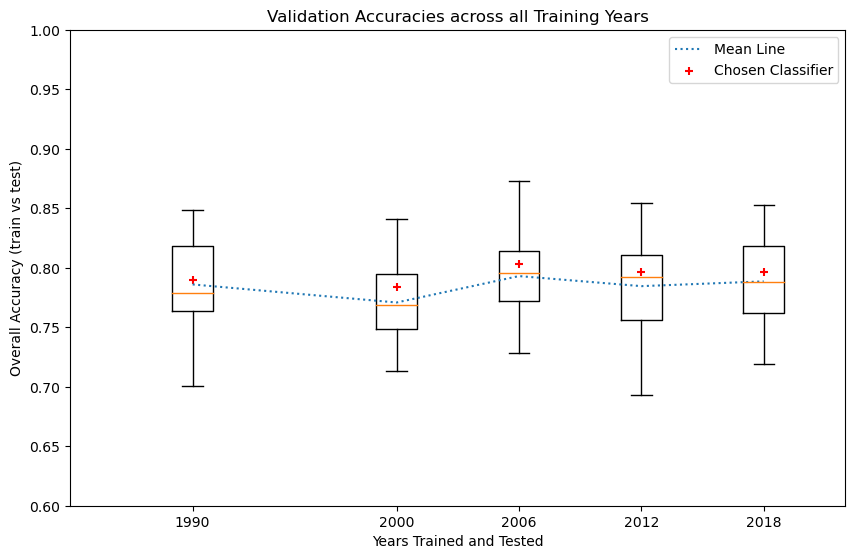

In [83]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = class_search.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')

ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

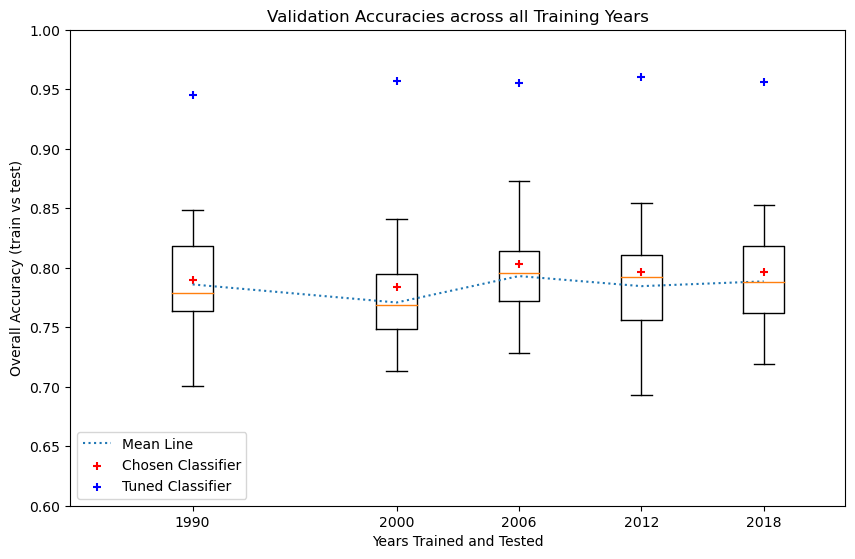

In [86]:
fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.scatter(year_classified, acc_post, marker='+', c='b', label='Tuned Classifier')
ax.set_xlabel('Years Trained and Tested')
ax.set_ylabel('Overall Accuracy (train vs test)')
ax.set_ylim(0.6, 1)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

In [ ]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map